# FCN Evaluation

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import json
import torch
from torchvision import transforms

from loader import transform
from models import FCN8s_voc, Config
from loader import get_loader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
config = Config()
config.data="voc2012"
config.data_path = 'datasets/VOCdevkit/'
config.batch_size = 4
state_path = 'ckpt/fcn8s_hybrid_5e-5.pth'

model = torch.nn.DataParallel(FCN8s_voc(config))
model.eval()
model.load_state_dict(torch.load(state_path, map_location=device))

<All keys matched successfully>

## Sample

In [3]:
root = 'sample/'
imgs = [Image.open(root + str(i) + '.jpg') for i in range(3)]
labels = [Image.open(root + str(i) + '_label.png') for i in range(3)]
palette = labels[0].getpalette()

data = [transform(config)(img) for img in imgs]
data = torch.stack(data)

In [4]:
with torch.no_grad():
    logit = model(data)

predicted_label = (torch.argmax(logit, dim=1)).cpu()

In [5]:
def label_to_img(label, size):
    img = transforms.ToPILImage()(transforms.Resize(size[::-1])(label.unsqueeze(0) / 255))
    img.putpalette(palette)
    return img

predicted_mask = [label_to_img(pred, img.size) for pred, img in zip(predicted_label, imgs)]

for i, img in enumerate(predicted_mask):
    img.save(root + str(i) + '_predicted.png')

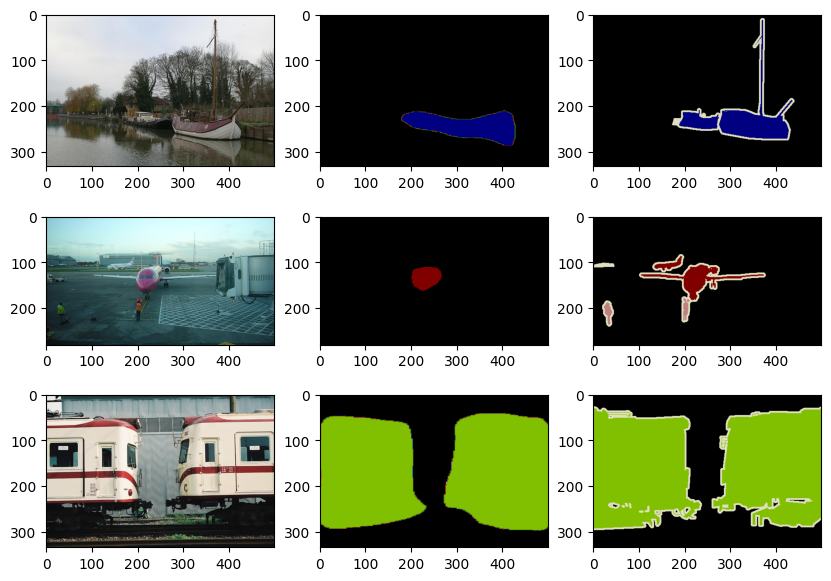

In [6]:
plt.figure(figsize=(10, 7))
plt.axis('off')

for i in range(len(imgs)):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(imgs[i])
    plt.subplot(3, 3, 3*i+2)
    plt.imshow(predicted_mask[i])
    plt.subplot(3, 3, 3*i+3)
    plt.imshow(labels[i])

# plt.axis("image")
plt.show()

## Performance

In [7]:
raw_log = json.load(open("logs/fcn8s_hybrid_5e-5.json", 'r'))

In [8]:
train_log, val_log = [(lambda l: torch.tensor(l[:-1] + [l[-1] + [[torch.nan] * 2] * (len(l[-2]) - len(l[-1]))]
                                    ).nanmean(dim=-2))([[list(step_info.values()) 
                                            for step_info in ep_info[mode].values()]
                                            for ep_info in raw_log['history'].values()])
                                            for mode in ('train', 'val')]

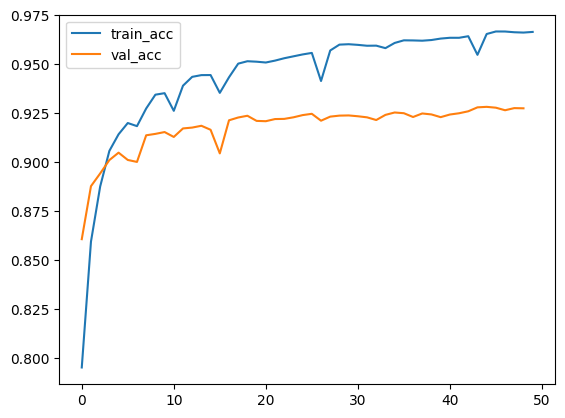

In [9]:
plt.plot(train_log[:,0], label="train_acc")
plt.plot(val_log[:,0], label="val_acc")
plt.legend()

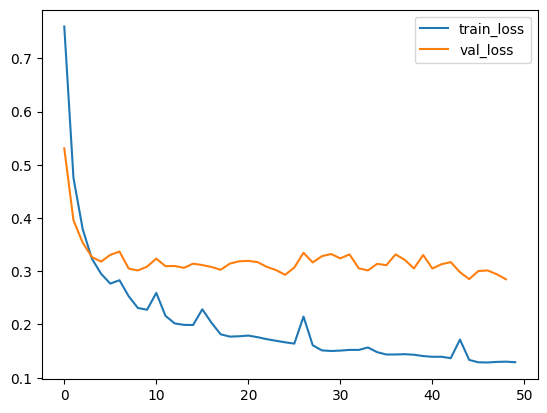

In [10]:
plt.plot(train_log[:,1], label="train_loss")
plt.plot(val_log[:,1], label="val_loss")
plt.legend()

## IoU & pixel acc

In [11]:
class_name = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv/monitor', "void/unlabelled"] 

In [12]:
loader = get_loader(config,train=True)

In [13]:
statistics = []
i = torch.arange(21, device=device).view([1, 21, 1, 1])
for data, label in loader:
    data, label = data.to(device), label.to(device)
    with torch.no_grad():
        logit = model(data)
    pred = logit.argmax(dim=1, keepdim=True)

    pred_mtx, label_mtx = pred == i, label == i
    
    intersect = torch.logical_and(pred_mtx, label_mtx).sum(dim=(-1, -2))
    union = torch.logical_or(pred_mtx, label_mtx).sum(dim=(-1, -2))
    all = label_mtx.sum(dim=(-1, -2))

    statistics.append(torch.stack([intersect, union, all], dim=0))
statistics = torch.concatenate(statistics, dim=1).cpu()

In [14]:
IoU = (statistics[0] / statistics[1]).nanmean(dim=0)
pixel_acc = (statistics[0] / statistics[2]).nanmean(dim=0)

order = IoU.argsort(descending=True)

In [15]:
print(f"{'name':<12}  {'IoU':<5}  {'pixel acc'}")
for i in order:
    print(f"{class_name[i]:<12}  {IoU[i].item()*100:.1f}  {pixel_acc[i].item()*100:.1f}")

name          IoU    pixel acc
background    89.0  97.5
train         73.9  92.0
cat           72.5  93.1
tv/monitor    69.0  77.5
horse         58.9  81.5
person        58.7  76.7
aeroplane     57.8  85.9
car           56.4  79.7
sheep         55.8  82.1
dog           52.7  91.0
bus           51.3  88.0
diningtable   50.2  67.7
motorbike     50.2  85.3
cow           48.2  83.6
sofa          48.0  63.7
bird          41.2  83.0
bottle        40.2  60.7
pottedplant   38.2  72.4
boat          37.8  84.6
chair         30.4  58.6
bicycle       16.1  69.9
